# Watermark Analysis

Notebook for performing analysis and visualization of the effects of watermarking schemes

In [1]:
# Basic imports
import os

from tqdm import tqdm
from statistics import mean

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import cmasher as cmr

In [2]:
from datasets import load_from_disk

C:\Users\viene\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the processed dataset/frame

In [3]:
# save_name = "analysis_ds_1-19_realnews_1-3_v1" # in figure
# save_name = "analysis_ds_1-21_greedy_redo" 
# save_name = "analysis_ds_1-21_greedy_redo_truncated"
# save_name = "analysis_ds_1-23_greedy_gamma_0-25_truncated" 
# save_name = "analysis_ds_1-23_greedy_gamma_0-25_0-5_truncated" # in figure (not 100% sure this is correct, check)

# save_name = "analysis_ds_1-20_more_attack" # in figure

# save_name = "analysis_ds_1-19_realnews_1-3_v1" # in figure
# save_name = "analysis_ds_1-23_en_1-3"
# save_name = "analysis_ds_1-23_pile_1-3"
save_name = "analysis_fig_2_a"

save_dir = f"input/{save_name}"

In [4]:
raw_data = load_from_disk(save_dir)

#### convert to pandas df

In [5]:
df = raw_data.to_pandas()

In [6]:
print(f"Orig number of rows: {len(df)}")
df.tail()

Orig number of rows: 250


,idx,truncated_input,baseline_completion,orig_sample_length,prompt_length,real_completion_length,no_bl_gen_time,w_bl_gen_time,spike_entropies,no_bl_output,...,w_bl_num_toks_gend_eq_0,w_bl_whitelist_fraction,w_bl_blacklist_fraction,w_bl_hit_list,avg_spike_entropy,w_bl_exp_num_wl_tokens,w_bl_var_num_wl_tokens,exp_wl_coef,w_bl_exp_whitelist_fraction,w_bl_var_whitelist_fraction
245,58,"Every morning on The Style Blog, we celebrate ...",". Now, for your benefit, it's all in one place...",247,47,200,3.162520,3.671558,"[[0.7106574177742004, 0.996288001537323, 0.976...",the same. I would be in the moment that we ha...,...,False,0.989950,0.010050,"[False, False, False, False, False, False, Fal...",0.946091,187.951848,11.322362,0.993307,0.939759,0.056612
246,59,It may not have been enough to bring out the s...,"on several days in late June, as well as in J...",334,134,200,3.178389,3.709032,"[[0.9763913154602051, 0.9936835765838623, 0.99...",City Halland a child. and so far too.Pawal of...,...,False,1.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.969507,192.603659,7.122811,0.993307,0.963018,0.035614
247,60,LOS ANGELES – A lawsuit filed Wednesday agains...,", the premise of which is to promote, protect ...",671,471,200,3.362706,3.865034,"[[0.9823671579360962, 0.9902862906455994, 0.92...",in the other� and the idea of 3000+ a new age...,...,False,0.989950,0.010050,"[False, False, False, False, False, False, Fal...",0.959324,190.580600,8.975774,0.993307,0.952903,0.044879
248,61,Are stoners now a target advertising demograph...,Taco Bell has seen its sales spike by 6 perce...,673,473,200,3.403688,3.842033,"[[0.996699333190918, 0.9463422894477844, 0.996...","This is one of the situation., if you know ho...",...,False,0.994975,0.005025,"[False, False, False, False, False, False, Fal...",0.949810,188.690672,10.669823,0.993307,0.943453,0.053349
249,62,"Seren Rayne Frank Sutherland, a six lb., eight...",Eduardo Velasco of Prescott Valley.\nTeagan M...,287,87,200,3.233525,3.617526,"[[0.9955215454101562, 0.9974445104598999, 0.96...","Davies, a U.\n\nTgle a couple of the early 19...",...,False,0.985000,0.015000,"[False, False, False, False, False, False, Fal...",0.946653,188.063488,11.224111,0.993307,0.940317,0.056121


In [190]:
df.columns

Index(['idx', 'truncated_input', 'baseline_completion', 'orig_sample_length',
       'prompt_length', 'real_completion_length', 'no_bl_gen_time',
       'w_bl_gen_time', 'no_bl_output', 'w_bl_output',
       'no_bl_num_tokens_generated', 'w_bl_num_tokens_generated',
       'no_bl_sec_per_tok', 'no_bl_tok_per_sec', 'w_bl_sec_per_tok',
       'w_bl_tok_per_sec', 'baseline_loss', 'baseline_ppl', 'no_bl_loss',
       'no_bl_ppl', 'w_bl_loss', 'w_bl_ppl', 'model_name', 'dataset_name',
       'dataset_config_name', 'shuffle_dataset', 'shuffle_seed',
       'shuffle_buffer_size', 'max_new_tokens', 'min_prompt_tokens',
       'min_sample_tokens', 'limit_indices', 'input_truncation_strategy',
       'input_filtering_strategy', 'output_filtering_strategy', 'initial_seed',
       'dynamic_seed', 'bl_proportion', 'bl_logit_bias', 'bl_type',
       'num_beams', 'no_repeat_ngram_size', 'early_stopping',
       'oracle_model_name', 'no_wandb', 'wandb_project', 'wandb_entity',
       'run_name', 'outp

### "retokenization" problem 

current hypo for what matches this criterion is based on the non 1-to-1 aspect of tokenization

In [7]:
retok_problematic_rows = df[(df['w_bl_whitelist_fraction'] != -1.0) & (df['w_bl_whitelist_fraction'] != 1.0) & (df['bl_type'] == 'hard')]
print(f"Num rows that are hard-blacklisted, and measureable, but still have a non-100% WL fraction: {len(retok_problematic_rows)} out of {len(df[df['bl_type'] == 'hard'])}")
# retok_problematic_rows

Num rows that are hard-blacklisted, and measureable, but still have a non-100% WL fraction: 0 out of 0


#### Replace or drop the the specially marked -1 rows since these are unmeasureable due to short length

In [8]:
orig_len = len(df)

# df['no_bl_whitelist_fraction'].mask(df['no_bl_whitelist_fraction'] == -1.0, pd.NA, inplace=True)
# df['w_bl_whitelist_fraction'].mask(df['w_bl_whitelist_fraction'] == -1.0, pd.NA, inplace=True)

df = df[df["no_bl_whitelist_fraction"] != -1.0]
df = df[df["w_bl_whitelist_fraction"] != -1.0]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

Dropped 1 rows, new len 249


#### Drop rows where there weren't enough tokens to measure ppl in one or both of the output cases

In [9]:
orig_len = len(df)
# df = df[df["no_bl_ppl"].isna()]
# df = df[df["w_bl_ppl"].isna()]
df = df[~(df["no_bl_ppl"].isna() | df["w_bl_ppl"].isna())]
print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

Dropped 0 rows, new len 249


#### drop rows with really large bias, as 100.0 is $\simeq \infty$

In [10]:
orig_len = len(df)

df = df[df["bl_logit_bias"] <= 100.0]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

Dropped 0 rows, new len 249


#### drop rows where using sampling but also beam search, not considering at this time

In [11]:
orig_len = len(df)

# df = df[df["bl_hparams"].apply(lambda tup: (tup[0] == False and tup[2] != 1) or (tup[0] == True and tup[2] == 1) or (tup[0] == False))]
df = df[((df["use_sampling"]==True) & (df["num_beams"] == 1)) | (df["use_sampling"]==False)]

print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

Dropped 0 rows, new len 249


#### correct the sampling temp column

In [12]:
df.loc[df["use_sampling"]==False,"sampling_temp"] = df.loc[df["use_sampling"]==False,"sampling_temp"].fillna(0.0)
df.loc[df["use_sampling"]==True,"sampling_temp"] = df.loc[df["use_sampling"]==True,"sampling_temp"].fillna(1.0)

#### marking the hard blacklist rows as having inf/very large bias

(after the > 100.0 bias drop)

In [13]:
df.loc[df["bl_type"]=="hard","bl_logit_bias"] = np.inf
# df.loc[df["bl_type"]=="hard","bl_logit_bias"] = 10000 # crosscheck with whats hardcoded in the bl processor

#### Rename some parameters

In [14]:
df["delta"] = df["bl_logit_bias"].values
df["gamma"] = 1 - df["bl_proportion"].values
df["gamma"] = df["gamma"].round(3)

df["no_bl_act_num_wl_tokens"] = np.round(df["no_bl_whitelist_fraction"].values*df["no_bl_num_tokens_generated"],1) # round to 1 for sanity
df["w_bl_act_num_wl_tokens"] = np.round(df["w_bl_whitelist_fraction"].values*df["w_bl_num_tokens_generated"],1) # round to 1 for sanity

# df["w_bl_std_num_wl_tokens"] = np.sqrt(df["w_bl_var_num_wl_tokens"].values)

if "real_completion_length":
    df["baseline_num_tokens_generated"] = df["real_completion_length"].values

if "actual_attacked_ratio" in df.columns:
    df["actual_attacked_fraction"] = df["actual_attacked_ratio"].values*df["replace_ratio"].values

if "meta" in df.columns:
    df["pile_set_name"] = df["meta"].apply(lambda dict: dict["pile_set_name"])

df["baseline_hit_list_length"] = df["baseline_hit_list"].apply(len)
df["no_bl_hit_list_length"] = df["no_bl_hit_list"].apply(len)
df["w_bl_hit_list_length"] = df["w_bl_hit_list"].apply(len)

In [15]:
# for pile outlier filtering
df["w_bl_space_count"] = df["w_bl_output"].apply(lambda string: string.count(" "))
df["no_bl_space_count"] = df["no_bl_output"].apply(lambda string: string.count(" "))
df["baseline_space_count"] = df["baseline_completion"].apply(lambda string: string.count(" "))

df["w_bl_space_frac"] = df["w_bl_space_count"].values / df["w_bl_hit_list_length"]
df["no_bl_space_frac"] = df["no_bl_space_count"].values / df["no_bl_hit_list_length"]
df["baseline_space_frac"] = df["baseline_space_count"].values / df["baseline_hit_list_length"]

### Filter for the generation lengths we want to look at

In [16]:
orig_len = len(df)

# # main filters
# # df = df[(df["real_completion_length"] == 200) & (df["w_bl_num_tokens_generated"] == 200)]
# df = df[(df["gamma"] == 0.1) | (df["gamma"] == 0.25) | (df["gamma"] == 0.5)]
# df = df[(df["delta"] == 1.0) | (df["delta"] == 2.0) | (df["delta"] == 10.0)]
# df = df[(df["use_sampling"] == True)]
# df = df[(df["bl_type"] == "soft")]

# df = df[(df["real_completion_length"] == 200) & (df["no_bl_num_tokens_generated"] == 200) & (df["w_bl_num_tokens_generated"] == 200)] # now also applies to the truncated version
# df = df[(df["no_bl_num_tokens_generated"] >= 500) & (df["w_bl_num_tokens_generated"] >= 500)] # all gas noop

# # # attack specific
# df = df[(df["real_completion_length"] == 200) & (df["no_bl_num_tokens_generated"] == 200) & (df["w_bl_num_tokens_generated"] == 200)]
# df = df[(df["replace_ratio"] <= 0.7)]

# NOTE pile only
# df = df[df["w_bl_space_frac"] <= 0.9]
# df = df[df["no_bl_space_frac"] <= 0.9]
# df = df[df["pile_set_name"] != "Github"]

upper_T = 205
lower_T = 195
print(df["baseline_hit_list_length"])
df = df[(df["baseline_hit_list_length"] >= lower_T) & (df["no_bl_hit_list_length"] >= lower_T) & (df["w_bl_hit_list_length"] >= lower_T)] # now also applies to the truncated version
df = df[(df["baseline_hit_list_length"] <= upper_T) & (df["no_bl_hit_list_length"] <= upper_T) & (df["w_bl_hit_list_length"] <= upper_T)] # now also applies to the truncated version


print(f"Dropped {orig_len-len(df)} rows, new len {len(df)}")

0      201
1      200
2      201
3      200
4      200
      ... 
245    200
246    200
247    200
248    200
249    200
Name: baseline_hit_list_length, Length: 249, dtype: int64
Dropped 42 rows, new len 207


# Add z-scores (convert the raw watermark measurement, fraction, to a z-score )

In [17]:
from math import sqrt
import scipy.stats
def compute_z_score(observed_wl_frac, T, gamma):
    numer = observed_wl_frac - gamma
    denom = sqrt(gamma*(1-gamma)/T)
    z = numer/denom
    return z

def compute_wl_for_z(z, T, gamma):
    denom = sqrt(gamma*(1-gamma)/T)
    numer = ((z*denom)+gamma)*T
    return numer

def compute_p_value(z):
    p_value = scipy.stats.norm.sf(abs(z))
    return p_value

df["baseline_z_score"] = df[["baseline_whitelist_fraction", "baseline_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
df["no_bl_z_score"] = df[["no_bl_whitelist_fraction", "no_bl_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)
df["w_bl_z_score"] = df[["w_bl_whitelist_fraction", "w_bl_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)

print(df["no_bl_z_score"])

if "w_bl_attacked_whitelist_fraction" in df.columns:
    df["w_bl_attacked_z_score"] = df[["w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)

0      2.262742
1     -0.141421
2      0.781726
3     -1.697056
4      1.697056
         ...   
245   -2.545584
246   -2.629442
247   -0.989949
248   -0.923858
249    0.639594
Name: no_bl_z_score, Length: 207, dtype: float64


In [18]:
# if attacked in df
if "w_bl_attacked_whitelist_fraction" in df.columns:
    df["w_bl_attacked_act_num_wl_tokens"] = np.round(df["w_bl_attacked_whitelist_fraction"].values*df["w_bl_attacked_num_tokens_generated"],1) # round to 1 for sanity

    df["w_bl_attacked_z_score"] = df[["w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated", "gamma"]].apply(lambda tup: compute_z_score(*tup), axis=1)

    df[["bl_proportion","w_bl_attacked_whitelist_fraction", "w_bl_attacked_num_tokens_generated","w_bl_attacked_act_num_wl_tokens", "w_bl_attacked_z_score"]]

# Prepare groupby (decide which hyperparameters to groups the rows by)

In [19]:
# groupby_fields = ['num_beams', 'max_new_tokens']
# groupby_fields = ['use_sampling','num_beams', 'max_new_tokens']
# groupby_fields = ['use_sampling','num_beams', 'max_new_tokens', 'bl_logit_bias']
# groupby_fields = ['use_sampling','num_beams', 'max_new_tokens', 'bl_type','bl_logit_bias']
# groupby_fields = ['use_sampling','sampling_temp','num_beams', 'max_new_tokens', 'bl_type','bl_logit_bias']
# groupby_fields = ['use_sampling','sampling_temp','num_beams', 'max_new_tokens', 'bl_type','bl_logit_bias','bl_proportion']
# groupby_fields = ['use_sampling','num_beams','bl_type','bl_logit_bias','bl_proportion']

if "w_bl_attacked_whitelist_fraction" in df.columns: 
    groupby_fields = ['use_sampling','num_beams','gamma','delta', 'replace_ratio'] # attack grouping
else:
    # groupby_fields = ['use_sampling','num_beams','delta','gamma'] # regular grouping
    # groupby_fields = ['use_sampling','delta','gamma'] # regular grouping, but no beam variation
    groupby_fields = ['delta','gamma'] # regular grouping, but no beam variation, and all sampling

print(groupby_fields)

['delta', 'gamma']


### narrowing in on IQ range (not generally used)

(removing outliers by subsetting to rows near the mean etc.)

In [204]:
# tmp_grped_25 = df.groupby(groupby_fields, as_index= False)['avg_spike_entropy'].quantile(q=0.25).rename(columns={'avg_spike_entropy': 'avg_spike_entropy_25th'})
# tmp_grped_50 = df.groupby(groupby_fields, as_index= False)['avg_spike_entropy'].quantile(q=0.5).rename(columns={'avg_spike_entropy': 'avg_spike_entropy_50th'})
# tmp_grped_75 = df.groupby(groupby_fields, as_index= False)['avg_spike_entropy'].quantile(q=0.75).rename(columns={'avg_spike_entropy': 'avg_spike_entropy_75th'})
# df = df.merge(tmp_grped_25, on = groupby_fields)
# df = df.merge(tmp_grped_50, on = groupby_fields)
# df = df.merge(tmp_grped_75, on = groupby_fields)

# # tmp_grped_mean = df.groupby(groupby_fields, as_index= False)['avg_spike_entropy'].mean().rename(columns={'avg_spike_entropy': 'avg_spike_entropy_mean'})
# # tmp_grped_median = df.groupby(groupby_fields, as_index= False)['avg_spike_entropy'].median().rename(columns={'avg_spike_entropy': 'avg_spike_entropy_median'})
# # df = df.merge(tmp_grped_mean, on = groupby_fields)
# # df = df.merge(tmp_grped_median, on = groupby_fields)


In [205]:
# # eps = 0.001
# eps = 0.005
# df["avg_spike_entropy_mean_minus_eps"] = df['avg_spike_entropy_mean']-eps
# df["avg_spike_entropy_mean_plus_eps"] = df['avg_spike_entropy_mean']+eps

# df["avg_spike_entropy_median_minus_eps"] = df['avg_spike_entropy_median']-eps
# df["avg_spike_entropy_median_plus_eps"] = df['avg_spike_entropy_median']+eps
# print(df.columns)

In [206]:
# # df[["avg_spike_entropy_25th","avg_spike_entropy_75th"]]
# df[["avg_spike_entropy_mean_minus_eps","avg_spike_entropy_mean","avg_spike_entropy_mean_plus_eps"]]
# df[["avg_spike_entropy_median_minus_eps","avg_spike_entropy_median","avg_spike_entropy_median_plus_eps"]]

In [207]:
# orig_len = len(df)

# subdf = df[(df["avg_spike_entropy"] >= df["avg_spike_entropy_25th"]) & (df["avg_spike_entropy"] <= df["avg_spike_entropy_75th"])]

# # subdf = df[(df["avg_spike_entropy"] >= df["avg_spike_entropy_mean_minus_eps"]) & (df["avg_spike_entropy"] <= df["avg_spike_entropy_mean_plus_eps"])]
# # subdf = df[(df["avg_spike_entropy"] >= df["avg_spike_entropy_mean_minus_eps"]) & (df["avg_spike_entropy"] <= df["avg_spike_entropy_mean_plus_eps"])]

# print(f"Dropped {orig_len-len(subdf)} rows, new len {len(subdf)}")

In [208]:
# subdf.groupby(groupby_fields)['avg_spike_entropy'].describe()
# df.groupby(groupby_fields)['avg_spike_entropy'].describe()

In [209]:
# df = subdf

# Perform the groupby (group rows by their hyperparameter settings)

In [20]:
grouped_df = df.groupby(groupby_fields)

In [21]:
print(f"Number of rows after filtering: {len(df)}")
print(f"Number of groups: {len(grouped_df)}")

Number of rows after filtering: 207
Number of groups: 5


# Loop to compute "confusion matrix" (TPR,FPR etc.) at some z scores for tabulation (Table 2 & 8)

In [212]:
import sklearn.metrics as metrics

def reject_null_hypo(z_score=None,cuttoff=None):
    return z_score > cuttoff

records = []

for group_params in tqdm(list(grouped_df.groups.keys())):
    sub_df = grouped_df.get_group(group_params)
    grp_size = len(sub_df)

    # baseline_z_scores = sub_df["baseline_z_score"].values
    # w_bl_z_scores = sub_df["w_bl_z_score"].values
    # all_scores = np.concatenate([baseline_z_scores,w_bl_z_scores])

    # baseline_labels = np.zeros_like(baseline_z_scores)
    # attacked_labels = np.ones_like(w_bl_z_scores)
    # all_labels = np.concatenate([baseline_labels,attacked_labels])

    # fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
    # roc_auc = metrics.auc(fpr, tpr)
    record = {k:v for k,v in zip(groupby_fields,group_params)}

    for thresh in [4.0,5.0]:
        
        record["count"] = grp_size
        record[f"baseline_fpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["baseline_z_score"].values,cuttoff=thresh).sum() / grp_size
        record[f"baseline_tnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["baseline_z_score"],cuttoff=thresh)).sum() / grp_size
        record[f"no_bl_fpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["no_bl_z_score"].values,cuttoff=thresh).sum() / grp_size
        record[f"no_bl_tnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["no_bl_z_score"].values,cuttoff=thresh)).sum() / grp_size
        record[f"w_bl_tpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["w_bl_z_score"].values,cuttoff=thresh).sum() / grp_size
        record[f"w_bl_fnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["w_bl_z_score"].values,cuttoff=thresh)).sum() / grp_size

        if "w_bl_attacked_z_score" in sub_df.columns:
            record[f"w_bl_attacked_tpr_at_{thresh}"] = reject_null_hypo(z_score=sub_df["w_bl_attacked_z_score"].values,cuttoff=thresh).sum() / grp_size
            record[f"w_bl_attacked_fnr_at_{thresh}"] = (~reject_null_hypo(z_score=sub_df["w_bl_attacked_z_score"].values,cuttoff=thresh)).sum() / grp_size

    records.append(record)

    #     # df[f"baseline_fp_at_{thresh}"] = reject_null_hypo(z_score=df["baseline_z_score"].values,cuttoff=thresh)
    #     # df[f"baseline_tn_at_{thresh}"] = ~reject_null_hypo(z_score=df["baseline_z_score"],cuttoff=thresh)
    #     # df[f"no_bl_fp_at_{thresh}"] = reject_null_hypo(z_score=df["no_bl_z_score"].values,cuttoff=thresh)
    #     # df[f"no_bl_tn_at_{thresh}"] = ~reject_null_hypo(z_score=df["no_bl_z_score"].values,cuttoff=thresh)
    #     # df[f"w_bl_tp_at_{thresh}"] = reject_null_hypo(z_score=df["w_bl_z_score"].values,cuttoff=thresh)
    #     # df[f"w_bl_fn_at_{thresh}"] = ~reject_null_hypo(z_score=df["w_bl_z_score"].values,cuttoff=thresh)


roc_df = pd.DataFrame.from_records(records)


100%|██████████| 5/5 [00:00<00:00, 1667.32it/s]


In [213]:
# thresh = 6.0
# thresh = 5.0
std_threshes = [4.0, 5.0] #, 6.0]
# std_threshes = [4.0]

# roc_df["params"] = roc_df.index.to_list()

# columns = ["num_beams", "delta", "gamma", "count"]
# columns = ["delta", "gamma", "count"]
columns = ["use_sampling","delta", "gamma", "count"]
# columns = ["use_sampling", "replace_ratio", "count"]

for thresh in std_threshes:
    # columns += [f"baseline_fpr_at_{thresh}",f"no_bl_fpr_at_{thresh}",f"w_bl_tpr_at_{thresh}"]
    # columns += [f"baseline_fpr_at_{thresh}",f"baseline_tnr_at_{thresh}",f"no_bl_fpr_at_{thresh}",f"no_bl_tnr_at_{thresh}",f"w_bl_tpr_at_{thresh}",f"w_bl_fn_at_{thresh}"]


    # columns += [f"baseline_fpr_at_{thresh}",f"baseline_tnr_at_{thresh}",f"w_bl_tpr_at_{thresh}",f"w_bl_fnr_at_{thresh}"]
    
    if f"w_bl_attacked_fnr_at_{thresh}" in roc_df.columns:
        columns += [f"w_bl_tpr_at_{thresh}",f"w_bl_fnr_at_{thresh}"]
        columns += [f"w_bl_attacked_tpr_at_{thresh}",f"w_bl_attacked_fnr_at_{thresh}"] # if attack
    else:
        columns += [f"baseline_fpr_at_{thresh}",f"baseline_tnr_at_{thresh}",f"w_bl_tpr_at_{thresh}",f"w_bl_fnr_at_{thresh}"]

# filter ot not
sub_df = roc_df[(roc_df["use_sampling"] == True) & ((roc_df["delta"] == 1.0) | (roc_df["delta"] == 2.0) | (roc_df["delta"] == 5.0))  &  ((roc_df["gamma"] == 0.25) |(roc_df["gamma"] == 0.5) )]
# sub_df = roc_df[(roc_df["use_sampling"] == False) & ((roc_df["delta"] == 1.0) | (roc_df["delta"] == 2.0) | (roc_df["delta"] == 5.0))  &  ((roc_df["gamma"] == 0.25) |(roc_df["gamma"] == 0.5) ) & (roc_df["num_beams"] == 8)]
# sub_df = roc_df[(roc_df["replace_ratio"] == 0.1) | (roc_df["replace_ratio"] == 0.3) | (roc_df["replace_ratio"] == 0.5)  | (roc_df["replace_ratio"] == 0.7)]
# sub_df = roc_df[(roc_df["num_beams"] == 8)]
# sub_df = roc_df

# sub_df.sort_values("delta")[columns]
# sub_df.sort_values("num_beams")[columns]
sub_df.sort_values(by=["delta","gamma"],ascending=[True, False])[columns]

KeyError: 'use_sampling'

#### write tables to latex

In [ ]:
# print(roc_df[columns].drop(["count"],axis=1).sort_values("gamma").round(3).to_latex(index=False))
# print(roc_df[columns].drop(["count"],axis=1).sort_values("delta").round(3).to_latex(index=False))
# print(roc_df[columns].drop(["count"],axis=1).sort_values("num_beams").round(3).to_latex(index=False))

# print(sub_df.sort_values(by=["delta","gamma"],ascending=[True, False])[columns].round(3).to_latex(index=False))
# print(sub_df.sort_values("num_beams")[columns].round(3).to_latex(index=False))

# ROC: No Attack (figure 4)

In [ ]:
plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))

import sklearn.metrics as metrics

# zoom = False
zoom = True

beam_search = None
# beam_search = 1
# beam_search = 4
# beam_search = 8

deltas = [0.5,1.0,2.0,5.0,10.0]
# gammas = [0.25, 0.5]
gammas = [0.25]
# gammas = [0.5]

# deltas = [1.0,2.0,5.0,10.0]
# gammas = [0.1,0.5]

groups = []
names = []
for d in deltas:
    for g in gammas:
        if beam_search:
            groups.append((False, beam_search, d, g))
        else:
            groups.append((True, 1, d, g))
        names.append(f"delta:{d}, gamma:{g}")
groups=groups[::-1]
names=names[::-1]

# Make colormap
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
viridis = plt.colormaps['viridis'].resampled(len(groups)+1) 
cmap = viridis.colors[:len(groups)][::-1]

# plot different parameter levels
for i,(group,name) in enumerate(zip(groups,names)):

    baseline_z_scores = grouped_df.get_group(group)["baseline_z_score"].values
    w_bl_z_scores = grouped_df.get_group(group)["w_bl_z_score"].values
    all_scores = np.concatenate([baseline_z_scores,w_bl_z_scores])

    baseline_labels = np.zeros_like(baseline_z_scores)
    attacked_labels = np.ones_like(w_bl_z_scores)
    all_labels = np.concatenate([baseline_labels,attacked_labels])

    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color=cmap[i], label = f'{name}, AUC:%0.3f, PPL:{round(grouped_df["w_bl_ppl"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3)

if "w_bl_attacked_ppl" in df.columns:
    pass
else:
    # # vanilla ppl value
    plt.scatter([-1],[-1],label=f'            delta=0, PPL: {round(grouped_df["no_bl_ppl"].describe().loc[groups,"mean"].mean(),1)}', color="white")

if zoom:
    if not "w_bl_attacked_ppl" in df.columns:
        plt.legend(loc = 'lower right', fontsize = 12)
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlim([0, 1])
    plt.ylim([0.5, 1])
    plot_name = ("roc_auc_zoom" if not beam_search else f"roc_auc_zoom_greedy_beams_{beam_search}")

else:
    if "w_bl_attacked_ppl" in df.columns:
        plt.legend(loc = 'lower right', fontsize = 12)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plot_name = ("roc_auc" if not beam_search else f"roc_auc_greedy_beams_{beam_search}")

plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)

print(plot_name)

# fname = f"{plot_name}.pdf"
# plt.savefig(fname, format="pdf")

plt.show()

ValueError: must supply a same-length tuple to get_group with multiple grouping keys

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>


# ROC: Attack (figure 6)

In [ ]:
import sklearn.metrics as metrics

plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))

# attack_budgets = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
attack_budgets = [0.1,0.3,0.5,0.7]
groups = [(True, 1, 0.5, 2.0, budget) for budget in attack_budgets]
beams = False
# groups = [(False, 8, 0.5, 2.0, budget) for budget in attack_budgets]
# beams = True

names = [f"$\epsilon={eps}$" for eps in attack_budgets]

# Make colormap
import matplotlib.pyplot as plt
viridis = plt.colormaps['viridis'].resampled(len(groups)+1+1) # attack
cmap = viridis.colors[:len(groups)+1][::-1]

# plot original
group = groups[0] # any will do
baseline_z_scores = grouped_df.get_group(group)["baseline_z_score"].values
baseline_labels = np.zeros_like(baseline_z_scores)

orig_watermark_z_scores = grouped_df.get_group(group)["w_bl_z_score"].values
watermark_labels = np.ones_like(orig_watermark_z_scores)

all_scores = np.concatenate([baseline_z_scores,orig_watermark_z_scores])
all_labels = np.concatenate([baseline_labels,watermark_labels])

fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color=cmap[0], label = f'unattacked, AUC:%0.3f, PPL:{round(grouped_df["w_bl_ppl"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3)

# plot different attack levels
for i,(group,name) in enumerate(zip(groups,names)):

    baseline_z_scores = grouped_df.get_group(group)["baseline_z_score"].values
    attacked_z_scores = grouped_df.get_group(group)["w_bl_attacked_z_score"].values
    all_scores = np.concatenate([baseline_z_scores,attacked_z_scores])

    baseline_labels = np.zeros_like(baseline_z_scores)
    attacked_labels = np.ones_like(attacked_z_scores)
    all_labels = np.concatenate([baseline_labels,attacked_labels])

    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color=cmap[i+1], label = f'{name}, AUC:%0.3f, PPL:{round(grouped_df["w_bl_attacked_ppl"].describe().loc[group]["mean"],1)}' % roc_auc, linewidth=3)

if "w_bl_attacked_ppl" in df.columns:
    pass
else:
    # # vanilla ppl value
    plt.scatter([-1],[-1],label=f'            $\delta=0$, PPL: {round(grouped_df["no_bl_ppl"].describe().loc[groups,"mean"].mean(),1)}', color="white")

zoom = False
# zoom = True
if zoom:
    if not "w_bl_attacked_ppl" in df.columns:
        plt.legend(loc = 'lower right')
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlim([0, 1])
    plt.ylim([0.5, 1])
    if "w_bl_attacked_ppl" in df.columns:
        plot_name = "roc_auc_untargeted_attack_no_beams_zoom"
        # plot_name = "roc_auc_untargeted_attack_with_beams_zoom"
    else:
        plot_name = "roc_auc_zoom"
else:
    if "w_bl_attacked_ppl" in df.columns:
        plt.legend(loc = 'lower right',fontsize = 9)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if "w_bl_attacked_ppl" in df.columns:
        if beams: plot_name = "roc_auc_untargeted_attack_w_beams"
        if not beams: plot_name = "roc_auc_untargeted_attack_no_beams"
    else:
        plot_name = "roc_auc"

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

print(plot_name)

# fname = f"figs/{plot_name}.pdf"
# plt.savefig(fname, format="pdf")

plt.show()

# Z vs T (figure 3)

C:\Users\viene\AppData\Local\Temp\ipykernel_10852\1875384657.py:99: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  wl_hit_matrix = (~torch.tensor(w_bl_hit_list, dtype=bool)).to(torch.float)
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


(10.0, 0.25)
dict_keys([(0.5, 0.25), (1.0, 0.25), (2.0, 0.25), (5.0, 0.25), (10.0, 0.25)])
[200, 199, 199, 199, 199, 199, 199, 162, 200, 198, 200, 200, 199, 160, 158, 159, 199, 196, 198, 200, 200, 200, 198, 199, 199, 198, 199, 198, 200, 200, 197, 197, 158, 200, 156, 199, 199, 200, 196, 197, 198, 199, 200, 200, 200, 160, 200, 198, 199, 200]
[]
(5.0, 0.25)
dict_keys([(0.5, 0.25), (1.0, 0.25), (2.0, 0.25), (5.0, 0.25), (10.0, 0.25)])
[197, 200, 198, 193, 200, 200, 156, 161, 198, 198, 199, 200, 200, 154, 158, 157, 200, 168, 200, 200, 200, 200, 199, 200, 198, 198, 199, 199, 199, 198, 197, 199, 200, 199, 199, 199, 200, 196, 198, 199, 200, 200, 199, 199, 202, 166, 199, 200, 200, 199]
[]
(2.0, 0.25)
dict_keys([(0.5, 0.25), (1.0, 0.25), (2.0, 0.25), (5.0, 0.25), (10.0, 0.25)])
[200, 200, 199, 198, 200, 200, 200, 200, 199, 200, 200, 199, 200, 199, 165, 163, 199, 169, 200, 199, 200, 200, 200, 199, 200, 200, 198, 200, 199, 198, 197, 156, 199, 158, 199, 198, 199, 198, 198, 199, 200, 200, 200, 199, 

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

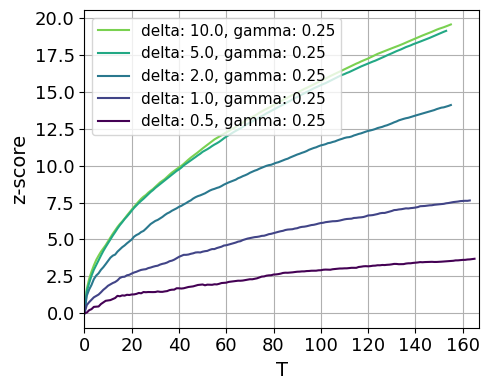

In [214]:
plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))

save_fig = True
# save_fig = False

z_scores = True
# z_scores = False

beam_search = None
# beam_search = 1
# beam_search = 4
# beam_search = 8

ablate = "delta"
delta_gammas = [
    (0.5,0.25),
    (1.0,0.25),
    (2.0,0.25),
    (5.0,0.25),
    (10.0,0.25),
#     (0.5,0.5),
#     (1.0,0.5),
#     (2.0,0.5),
#     (5.0,0.5),
#     (10.0,0.5),
]
# ablate = "gamma"
# delta_gammas = [
#     (5.0,0.9),
#     (5.0,0.75),
#     (5.0,0.5),
#     (5.0,0.25),
#     (5.0,0.1),
    # (2.0,0.9),
    # (2.0,0.75),
    # (2.0,0.5),
    # (2.0,0.25),
    # (2.0,0.1),
# ]
if not z_scores: delta_gammas = delta_gammas[::-1]

groups = []
names = []

for d,g in delta_gammas:
        if beam_search:
            groups.append((False, beam_search, d, g))
        else:
            groups.append((d, g))
        names.append(f"delta: {d}, gamma: {g}")

groups=groups[::-1]
names=names[::-1]


axis_max_t = 200

max_t = None
# max_t = 200
# max_t = 100
# max_t = 50

# Make colormap
import matplotlib.pyplot as plt
viridis = plt.colormaps['viridis'].resampled(len(groups)+1) 
plt.rcParams['text.usetex'] = False
cmap = viridis.colors[:len(groups)][::-1]

for grp_idx,(group, name) in enumerate(zip(groups, names)):
    
    delta, gamma = group[-2],group[-1]

    print(group)
    print(grouped_df.groups.keys())
    # this is the series of bools corresponding to token at T being in whitelist
    w_bl_hit_list = grouped_df.get_group(group)["w_bl_hit_list"].to_list()


    lengths = [len(l) for l in w_bl_hit_list]
    print(lengths)
    diff_lengths = list(lengths) 
    counter = {}
    for l in lengths:
        if counter.get(l):
            counter[l] += 1
        else:
            counter[l] = 1
    if max_t:
        min_length = min(min(diff_lengths),max_t)
        max_t = min_length
    else:
        min_length = min(diff_lengths)
        
    w_bl_hit_list = [l[:min_length] for l in w_bl_hit_list]

    # wl_hit_matrix = ~np.matrix(w_bl_hit_list)
    wl_hit_matrix = (~torch.tensor(w_bl_hit_list, dtype=bool)).to(torch.float)
    # wl_hit_matrix

    n = wl_hit_matrix.shape[0]

    if max_t:
        t_values = torch.arange(0,max_t)
        indices = torch.arange(0,max_t)
    else:
        t_values = torch.arange(0,wl_hit_matrix.shape[1])
        indices = torch.arange(0,wl_hit_matrix.shape[1])
    # print(t_values[:10])

    avg_cumulative = list()
    std_cumulative = list()
    prc_25_cumulative = list()
    prc_50_cumulative = list()
    prc_75_cumulative = list()

    prc_25_seq_indices = list()

    for idx in indices:

        hits_upto_t = wl_hit_matrix[:,:idx+1]
        cumulative_sum_to_t = hits_upto_t.sum(axis=1)
        wl_frac_at_t = cumulative_sum_to_t/(t_values[idx]+1)
        
        if z_scores:
            wl_z_score_at_t = compute_z_score(wl_frac_at_t, t_values[idx], gamma)
            avg_at_t = torch.mean(wl_z_score_at_t,axis=0)
            std_at_t = torch.std(wl_z_score_at_t,axis=0)
            prc_25_at_t = torch.quantile(wl_z_score_at_t,q=0.25,axis=0)
            prc_50_at_t = torch.quantile(wl_z_score_at_t,q=0.50,axis=0)
            prc_75_at_t = torch.quantile(wl_z_score_at_t,q=0.75,axis=0)

            if gamma == 0.9: # and idx > 20 and idx < 90:
                pcen=np.quantile(wl_z_score_at_t,0.75,interpolation='nearest')
                i_near=abs(wl_z_score_at_t-pcen).argmin()
                # prc_25_seq_indices.append((i_near.item(),pcen))
                prc_25_seq_indices.append((i_near.item()))
        else:
            avg_at_t = torch.mean(wl_frac_at_t,axis=0)
            std_at_t = torch.std(wl_frac_at_t,axis=0)
            prc_25_at_t = torch.quantile(wl_frac_at_t,q=0.25,axis=0)
            prc_50_at_t = torch.quantile(wl_frac_at_t,q=0.50,axis=0)
            prc_75_at_t = torch.quantile(wl_frac_at_t,q=0.75,axis=0)

        avg_cumulative.append(avg_at_t.item())
        std_cumulative.append(std_at_t.item())
        prc_25_cumulative.append(prc_25_at_t.item())
        prc_50_cumulative.append(prc_50_at_t.item())
        prc_75_cumulative.append(prc_75_at_t.item())


    print(prc_25_seq_indices)

    avg_cumulative = np.array(avg_cumulative)
    std_cumulative = np.array(std_cumulative)
    std_err_cumulative = std_cumulative/np.sqrt(n)
    var_cumulative = std_cumulative**2
    
    plt.plot(t_values, avg_cumulative, color=cmap[grp_idx],  label=name)

    # bounds stuff

    # plt.plot(t_values, prc_25_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # # plt.plot(t_values, prc_50_cumulative, color=cmap[grp_idx], linestyle='--', label=name+',50th') 
    # plt.plot(t_values, prc_75_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',75th ') 
    # #fill between the upper and lower bands
    # plt.fill_between(t_values, prc_25_cumulative, prc_75_cumulative, alpha = .1,color = cmap[grp_idx])
    # or just lower
    # plt.fill_between(t_values, prc_25_cumulative, avg_cumulative, alpha = .1,color = cmap[grp_idx])

    # plt.plot(t_values, avg_cumulative-std_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative+std_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative-std_err_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative+std_err_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative-var_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # plt.plot(t_values, avg_cumulative+var_cumulative, color=cmap[grp_idx], linestyle="dashed") #, label=name+',25th') 
    # fill between the upper and lower bands
    # plt.fill_between(t_values, avg_cumulative-std_cumulative, avg_cumulative+std_cumulative, alpha = .1,color = cmap[grp_idx])
    # plt.fill_between(t_values, avg_cumulative-std_err_cumulative, avg_cumulative+std_err_cumulative, alpha = .1,color = cmap[grp_idx])
    # or just lower
    # plt.fill_between(t_values, avg_cumulative-std_cumulative, avg_cumulative, alpha = .1,color = cmap[grp_idx])
    # plt.fill_between(t_values, avg_cumulative-std_err_cumulative, avg_cumulative, alpha = .1,color = cmap[grp_idx])

# plt.plot([0.0],[0.0],label=f'25th Percentile', linestyle="dashed", color="gray")

# if beam_search:
#     plt.title(f"Greedy, {beam_search}-way BS")

legend_font = 11

# zoom_midrange = True
# zoom = True

zoom = False

if zoom:
    if z_scores:
        plt.legend(loc = 'upper left', fontsize=legend_font)
    else:
        plt.legend(loc = 'lower right', fontsize=legend_font)
    if zoom_midrange:
        plt.xlim([(min_length)/4, (3*(max_t if max_t else min_length)/4)+1])
    else:
        plt.xlim([0, ((max_t if max_t else min_length)/4)+1])
    plot_name = f"z_vs_t_zoom_ablate_{ablate}" if z_scores else f"wl_vs_t_zoom_ablate_{ablate}"
else:
    if z_scores:
        plt.legend(loc = 'upper left', fontsize=legend_font)
    else:
        plt.legend(loc = 'lower right', fontsize=legend_font)
  
    plt.xlim([0, ((max_t if max_t else min_length))+1])

    plot_name = f"z_vs_t_ablate_{ablate}" if z_scores else f"wl_vs_t_ablate_{ablate}"

axes_label_fonts = 14
if z_scores:
    plt.ylabel('z-score',fontsize=axes_label_fonts)
else:
    plt.ylabel('Whitelist Fraction',fontsize=axes_label_fonts)
plt.xlabel('T',fontsize=axes_label_fonts)

# import matplotlib.ticker as ticker
# tick_spacing = 5.0
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

axes_tick_font = 13
plt.xticks(fontsize=axes_tick_font)
plt.yticks(fontsize=axes_tick_font)

plt.grid()
plt.tight_layout()

if beam_search:
    if ablate == "gamma":
        plot_name = f"greedy_{beam_search}_beams_delta_{delta}" 
    if ablate == "delta":
        plot_name = f"greedy_{beam_search}_beams_gamma_{gamma}" 

# plot_name = "z_vs_t_ablate_gamma_boosted_delta"
# plot_name = "z_vs_t_ablate_delta_boosted_gamma"

# print(plot_name)


# if save_fig:
#     # fname = f"figs/{plot_name}.pdf"
#     fname = f"figs_new/{plot_name}.pdf"
#     plt.savefig(fname, format="pdf")

plt.show()

# Set up data for charts (setup for figures 2&7)

In [32]:
viz_df = pd.DataFrame()

# aggregating

# set the hparam keys, including an indiv column for each you want to ablate on
viz_df["bl_hparams"] = grouped_df["w_bl_exp_whitelist_fraction"].describe().index.to_list()
for i,key in enumerate(groupby_fields):
    viz_df[key] = viz_df["bl_hparams"].apply(lambda tup: tup[i])

# viz_df["delta"] = viz_df["bl_logit_bias"].values
viz_df["gamma"] = viz_df["gamma"].values
# viz_df["gamma"] = np.ones_like(viz_df["bl_proportion"].values) - viz_df["bl_proportion"].values

# aggregate each field of interest for each hparam setting (group)
describe_dict = grouped_df["w_bl_exp_whitelist_fraction"].describe()
viz_df["w_bl_exp_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_exp_whitelist_fraction_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["w_bl_var_whitelist_fraction"].describe()
viz_df["w_bl_var_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_var_whitelist_fraction_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["w_bl_whitelist_fraction"].describe()
viz_df["w_bl_whitelist_fraction_min"] = describe_dict["min"].to_list()
viz_df["w_bl_whitelist_fraction_25"] = describe_dict["25%"].to_list()
viz_df["w_bl_whitelist_fraction_50"] = describe_dict["50%"].to_list()
viz_df["w_bl_whitelist_fraction_75"] = describe_dict["75%"].to_list()
viz_df["w_bl_whitelist_fraction_max"] = describe_dict["max"].to_list()
viz_df["w_bl_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_whitelist_fraction_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["no_bl_whitelist_fraction"].describe()
viz_df["no_bl_whitelist_fraction_mean"] = describe_dict["mean"].to_list()
viz_df["no_bl_whitelist_fraction_std"] = describe_dict["std"].to_list()


describe_dict = grouped_df["w_bl_z_score"].describe()
viz_df["w_bl_z_score_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_z_score_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["no_bl_z_score"].describe()
viz_df["no_bl_z_score_mean"] = describe_dict["mean"].to_list()
viz_df["no_bl_z_score_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["baseline_z_score"].describe()
viz_df["baseline_z_score_mean"] = describe_dict["mean"].to_list()
viz_df["baseline_z_score_std"] = describe_dict["std"].to_list()


describe_dict = grouped_df["w_bl_ppl"].describe()
viz_df["w_bl_ppl_mean"] = describe_dict["mean"].to_list()
viz_df["w_bl_ppl_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["no_bl_ppl"].describe()
viz_df["no_bl_ppl_mean"] = describe_dict["mean"].to_list()
viz_df["no_bl_ppl_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["baseline_ppl"].describe()
viz_df["baseline_ppl_mean"] = describe_dict["mean"].to_list()
viz_df["baseline_ppl_std"] = describe_dict["std"].to_list()

describe_dict = grouped_df["avg_spike_entropy"].describe()
viz_df["avg_spike_entropy_mean"] = describe_dict["mean"].to_list()
viz_df["avg_spike_entropy_std"] = describe_dict["std"].to_list()

print(f"groupby legend: {groupby_fields}")
print(viz_df)


groupby legend: ['delta', 'gamma']
    bl_hparams  delta  gamma  w_bl_exp_whitelist_fraction_mean  \
0   (0.0, 0.5)    0.0    0.5                          0.500000   
1   (1.0, 0.5)    1.0    0.5                          0.712760   
2   (2.0, 0.5)    2.0    0.5                          0.850290   
3   (5.0, 0.5)    5.0    0.5                          0.950075   
4  (10.0, 0.5)   10.0    0.5                          0.958548   

   w_bl_exp_whitelist_fraction_std  w_bl_var_whitelist_fraction_mean  \
0                     2.364566e-09                          0.250000   
1                     6.041891e-03                          0.204698   
2                     6.710233e-03                          0.127253   
3                     7.095571e-03                          0.047383   
4                     7.570393e-03                          0.039678   

   w_bl_var_whitelist_fraction_std  w_bl_whitelist_fraction_min  \
0                     4.807407e-17                     0.407035   
1

In [31]:
# filtering

# viz_df = viz_df[viz_df["bl_hparams"].apply(lambda tup: (tup[0] == True))] # sampling

# viz_df = viz_df[viz_df["bl_hparams"].apply(lambda tup: (tup[0] == False))] # greedy


# fix one of the bl params for analytic chart
# viz_df = viz_df[(viz_df["gamma"]==0.9) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.75) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.5) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.25) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["gamma"]==0.1) & (viz_df["delta"]<=10.0)]

# for the sample pareto chart
# viz_df = viz_df[(viz_df["delta"] >= 0.5) & (viz_df["delta"]<=10.0)]
# viz_df = viz_df[(viz_df["delta"]<=2.0)] # zoom in on lower deltas
# viz_df = viz_df[(viz_df["delta"] >= 2.0) & (viz_df["delta"]<=10.0)] # mid deltas
# viz_df = viz_df[(viz_df["gamma"] != 0.25) & (viz_df["gamma"] != 0.75) & (viz_df["delta"]<=2.0)]
# viz_df = viz_df[(viz_df["gamma"] != 0.1) & (viz_df["gamma"] != 0.9) & (viz_df["delta"]<=2.0)]

# viz_df = viz_df[(viz_df["delta"]==0.5) | (viz_df["delta"]==2.0) | (viz_df["delta"]==10.0)]

# viz_df = viz_df[(viz_df["delta"]!=0.1)&(viz_df["delta"]!=0.5)&(viz_df["delta"]!=50.0)]

# for the beams pareto
# viz_df = viz_df[(viz_df["delta"]!=50.0)]
# viz_df = viz_df[(viz_df["delta"]!=50.0) & (viz_df["num_beams"]!=1)]

print(len(viz_df))

viz_df

4


,bl_hparams,delta,gamma,w_bl_exp_whitelist_fraction_mean,w_bl_exp_whitelist_fraction_std,w_bl_var_whitelist_fraction_mean,w_bl_var_whitelist_fraction_std,w_bl_whitelist_fraction_min,w_bl_whitelist_fraction_25,w_bl_whitelist_fraction_50,...,baseline_z_score_mean,baseline_z_score_std,w_bl_ppl_mean,w_bl_ppl_std,no_bl_ppl_mean,no_bl_ppl_std,baseline_ppl_mean,baseline_ppl_std,avg_spike_entropy_mean,avg_spike_entropy_std
1,"(1.0, 0.5)",1.0,0.5,0.712760,0.006042,0.204698,0.002485,0.547739,0.720000,0.746193,...,0.346663,0.907218,67.671706,23.344588,72.263187,44.745572,413.053426,143.506631,0.974969,0.008265
2,"(2.0, 0.5)",2.0,0.5,0.850290,0.006710,0.127253,0.004705,0.865000,0.905000,0.915000,...,0.243184,0.873273,71.711132,22.741459,68.616169,26.328860,425.128655,147.226235,0.965364,0.007618
3,"(5.0, 0.5)",5.0,0.5,0.950075,0.007096,0.047383,0.006406,0.924242,0.984887,0.989950,...,0.399606,0.909768,90.632170,31.571472,68.295963,52.218469,420.230343,144.256600,0.956477,0.007143
4,"(10.0, 0.5)",10.0,0.5,0.958548,0.007570,0.039678,0.006985,0.959596,0.982336,0.989950,...,0.277412,0.826018,91.550818,37.887298,69.456197,45.047072,423.653989,151.621396,0.958591,0.007571


In [ ]:
# grouped_df["avg_spike_entropy"]

In [ ]:
# viz_df[["gamma","avg_spike_entropy_mean"]]

# Basic Exp vs Empirical WL fraction chart (figure 7)

In [ ]:

# plt.style.use("classic")
plt.style.use("default")
# plt.style.use('ggplot') 
# plt.style.use('seaborn')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


plt.clf()
# plt.figure(figsize=(16, 4))
# plt.figure(figsize=(8, 4))
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))


# x_col = 'bl_hparams'
# a = viz_df[x_col].apply(str)

# x_col = 'bl_logit_bias'
# x_col = 'bl_proportion'
x_col = "delta"
# x_col = "gamma"

a = viz_df[x_col]
print(f"Num configurations: {len(a)}")

y_col = 'w_bl_whitelist_fraction_mean'
y_col_err = 'w_bl_whitelist_fraction_std'

viridis = plt.colormaps['viridis'].resampled(4)
# cmap = viridis.colors[::-1]
cmap = viridis.colors

plt.plot(a, viz_df["w_bl_whitelist_fraction_mean"].values, color=cmap[1], marker='o', label='Mean') 
plt.plot(a, viz_df["w_bl_whitelist_fraction_25"].values, color=cmap[1], linestyle='-.', label='25th Percentile') 
plt.plot(a, viz_df["w_bl_whitelist_fraction_75"].values, color=cmap[1], linestyle='-.', label='75th Percentile') 
# plt.plot(a, viz_df["w_bl_whitelist_fraction_min"].values, color=cmap[1], linestyle='-.', label='min') 
# plt.plot(a, viz_df["w_bl_whitelist_fraction_max"].values, color=cmap[1], linestyle='-.', label='max') 

#fill between the upper and lower bands
plt.fill_between(a, viz_df["w_bl_whitelist_fraction_25"], viz_df["w_bl_whitelist_fraction_75"], alpha = .1,color = cmap[1])
# plt.fill_between(a, viz_df["w_bl_whitelist_fraction_25"], viz_df["w_bl_whitelist_fraction_75"], alpha = .1,color = 'darkorchid')
# plt.fill_between(a, y1_low, y1_high, alpha = .1,color = 'goldenrod')


y_col = 'w_bl_exp_whitelist_fraction_mean'
# y_col_err = 'w_bl_var_whitelist_fraction_mean'
# d = viz_df[x_col].apply(str)

# sub_df = viz_df[viz_df["num_beams"]==1]

a = viz_df[x_col]
e = viz_df[y_col].values
# plt.plot(a, e, label="Predicted Lower Bound", color=cmap[-1])
plt.plot(a, e, label="Analytic Bound", color="r")
# f = viz_df[y_col_err].values
# # f = np.sqrt(viz_df[y_col_err].values)
# plt.errorbar(d, e, yerr=f, fmt="o")

plt.legend(loc="lower right",frameon=True, facecolor="white")

# for logit bias x axis
# log_axis = True
log_axis = False
if log_axis:
    plt.xscale("log")

ax = plt.gca()
plt.draw()



plt.xlabel(f"Green List Bias, $\delta$")
# plt.xlabel(f"Whitelist size := $\gamma$")

plt.ylabel("Fraction in Green List")


plt.grid()

plt.tight_layout()

if log_axis:
    plot_name = "analytic_w_sampling_log.pdf"
else:
    plot_name = "analytic_w_sampling_linear.pdf"
    # plot_name = f"analytic_w_sampling_linear_gamma_{viz_df['gamma'].values[0]}.pdf"

# plot_name = "analytic_w_sampling_linear_greenlist.pdf"
print(plot_name)

# fname = f"figs/{plot_name}"
# plt.savefig(fname, format="pdf")
plt.show()


# delta gamma sampling pareto plot (figure 2 left)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

[0.0, 1.0, 2.0, 5.0, 10.0] [0.5]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

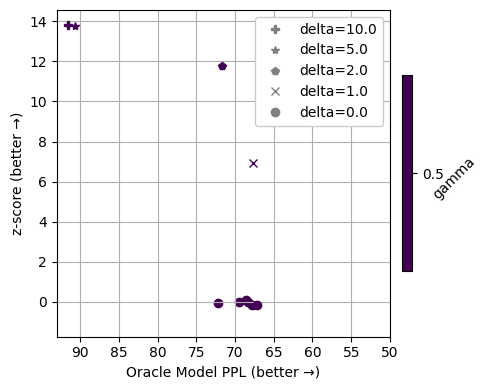

In [57]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = False

plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))


x_col = 'w_bl_ppl_mean'
y_col = 'w_bl_z_score_mean'

# markers = ["x", "p", "*", "P"]

deltas = sorted(np.unique(viz_df["delta"].values))
gammas = sorted(np.unique(viz_df["gamma"].values), reverse=True)
print(deltas, gammas)
gamma_labels = [(g if g > 0.1 else 0.1) for g in gammas]

markers = ["o", "x", "p", "*", "P"][:len(deltas)]

num_colors = len(gammas)
cmap = cmr.get_sub_cmap('viridis', 0.0, 0.66, N=num_colors)
# cmap = cmr.get_sub_cmap('plasma', 0.0, 0.66, N=num_colors)
colors = cmap.colors#[::-1]


for i,delta in enumerate(deltas):
    for j,gamma in enumerate(gammas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["gamma"] == gamma)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        # plt.scatter(a, b, label=f"$\delta={delta},\gamma={gamma}$", color=colors[j], marker=markers[i])
        plt.plot(a, b, label=f"delta={delta}, gamma={gamma}", color=colors[j], marker=markers[i])


x_col = 'no_bl_ppl_mean'
y_col = 'no_bl_z_score_mean'
# x_col = 'baseline_ppl_mean'
# y_col = 'baseline_z_score_mean'


for i,delta in enumerate(deltas):
    for j,gamma in enumerate(gammas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["gamma"] == gamma)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        plt.scatter(a, b, label=f"delta={delta}, gamma={gamma}", color=colors[j])

# # # for manual legend
plt.scatter([-1],[-1], label="Vanilla", color="gray", marker="o")

ax = plt.gca()

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, NoNorm, ListedColormap
cmap = ListedColormap(colors)
cmappable = ScalarMappable(norm=NoNorm(),cmap=cmap)
cbar = plt.colorbar(cmappable, ax=ax, ticks=[i for i in range(len(gammas))],shrink=0.6, pad = 0.03)
cbar.ax.set_yticklabels(gamma_labels) 
cbar.set_label('gamma', rotation=45)


all_x = np.concatenate([viz_df['w_bl_ppl_mean'].values,viz_df['no_bl_ppl_mean'].values])
all_y = np.concatenate([viz_df['w_bl_z_score_mean'].values,viz_df['no_bl_z_score_mean'].values])
# all_x = np.concatenate([viz_df['w_bl_ppl_mean'].values,viz_df['baseline_ppl_mean'].values])
# all_y = np.concatenate([viz_df['w_bl_z_score_mean'].values,viz_df['baseline_z_score_mean'].values])

min_x, max_x = np.min(all_x), np.max(all_x)
min_y, max_y = np.min(all_y), np.max(all_y)

x_min_tick = 50.0
# x_min_tick = 3.0
x_max_tick = np.ceil([max_x])[0]+1.0
y_min_tick = 0.0
y_max_tick = np.ceil([max_y])[0]+1.0

x_ticks = np.arange(x_min_tick,x_max_tick,5.0)
y_ticks = np.arange(y_min_tick,y_max_tick,5.0)


x_lim_min = 50.0
x_lim_max = x_max_tick
y_lim_min = 0.45
# y_lim_max = 1.09
y_lim_max = 1.005


# plt.xlim((x_min_tick-0.5,x_max_tick))
plt.xlim((x_lim_min,x_lim_max))
# plt.xlim((4.0,8.0))
# plt.ylim((-1.0,20.0))
# plt.ylim((y_lim_min,y_lim_max))

ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks)

ax.invert_xaxis()

# # manual legend for dual parameter visualization
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(markers[::-1][i], "gray") for i in range(len(deltas))]
handles += [f("o", "gray")]
labels = [f"delta={delta}" for delta in deltas[::-1]]
plt.legend(handles, labels, loc="upper right", framealpha=1)

plt.grid()

plt.xlabel("Oracle Model PPL (better →)")
plt.ylabel("z-score (better →)")


plt.tight_layout()

# plot_name = "pareto_sampling_no_beams"
# fname = f"figs/{plot_name}.pdf"
# plt.savefig(fname, format="pdf")
plt.show()

# beams pareto plot (figure 2 right)

In [ ]:
num_colors = 3
cmap = cmr.get_sub_cmap('viridis', 0.0, 0.66, N=num_colors)
colors = cmap.colors#[::-1]

# plt.style.use('ggplot')
# plt.style.use('seaborn')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.clf()
plt.figure(constrained_layout=True)
plt.figure(figsize=(5, 4))


x_col = 'w_bl_ppl_mean'
y_col = 'w_bl_z_score_mean'

markers = ["s","D", "x", "p",  "*", "P"] # <--- seems to match other pareto fig ordering

deltas = sorted(np.unique(viz_df["delta"].values))
num_beams = sorted(np.unique(viz_df["num_beams"].values))
# gamma_labels = [(g if g > 0.1 else 0.1) for g in np.unique(viz_df["gamma"].values)]

for i,n_beams in enumerate(num_beams):
    for j,delta in enumerate(deltas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["num_beams"] == n_beams)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        # plt.scatter(a, b, label=f"$\delta={delta},\gamma={gamma}$", color=colors[j], marker=markers[i])
        plt.plot(a, b, label=f"$\delta={delta}$", color=colors[i], marker=markers[j])


x_col = 'no_bl_ppl_mean'
y_col = 'no_bl_z_score_mean'



for i,n_beams in enumerate(num_beams):
    for j,delta in enumerate(deltas):
        sub_df = viz_df[(viz_df["delta"] == delta) & (viz_df["num_beams"] == n_beams)]
        a = sub_df[x_col].values
        b = sub_df[y_col].values
        plt.scatter(a, b, label=f"$\delta={delta}$", color=colors[i])

# # # for manual legend
plt.scatter([-10],[-10], label="$\delta=0$", color="gray", marker="o")

ax = plt.gca()

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, NoNorm, ListedColormap
cmap = ListedColormap(colors)
cmappable = ScalarMappable(norm=NoNorm(),cmap=cmap)
cbar = plt.colorbar(cmappable,ticks=[i for i in range(len(num_beams))],shrink=0.6, pad = 0.04)
# cbar.set_ticks(num_beams)
cbar.set_ticklabels(num_beams)
# cbar.ax.set_yticklabels(num_beams) 
cbar.set_label('Num Beams', rotation=90)


all_x = np.concatenate([viz_df['w_bl_ppl_mean'].values,viz_df['no_bl_ppl_mean'].values])
all_y = np.concatenate([viz_df['w_bl_z_score_mean'].values,viz_df['no_bl_z_score_mean'].values])

min_x, max_x = np.min(all_x), np.max(all_x)
min_y, max_y = np.min(all_y), np.max(all_y)

# x_max_tick = np.ceil([max_x])[0]+1.0
x_max_tick = np.ceil([max_x])[0]
y_max_tick = np.ceil([max_y])[0]+1.0


plt.xlim((1.0,x_max_tick))
plt.ylim((-1.0,y_max_tick))

# x_ticks = np.arange(x_min_tick,x_max_tick,1.0)
# y_ticks = np.arange(y_min_tick,y_max_tick,5.0)

# ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks)

ax.invert_xaxis()

# # manual legend for dual parameter visualization
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(markers[::-1][i], "gray") for i in range(len(deltas))]
handles += [f("o", "gray")]
labels = [f"$\delta={delta}$" for delta in deltas[::-1]]+[f"$\delta=0.0$"]
plt.legend(handles, labels, loc="lower left", framealpha=1)

plt.grid()

plt.xlabel("Oracle Model PPL (better →)")
plt.ylabel("z-score (better →)")


plt.tight_layout()


plot_name = "pareto_greedy_w_beams"
print(plot_name)

# fname = f"figs/{plot_name}.pdf"
# plt.savefig(fname, format="pdf")
plt.show()

## z vs entropy (not in paper)

In [ ]:
print(f"groupby legend: {groupby_fields}")
# hist_subset = grouped_df.get_group((True,1,2.0,0.1)) # needs to match the groupby keys and order
# hist_subset = grouped_df.get_group((True,1,2.0,0.25)) 
hist_subset = grouped_df.get_group((True,1,2.0,0.5)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.75)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.9)) 

In [ ]:
print(len(hist_subset))
# hist_subset = hist_subset[hist_subset["w_bl_space_frac"] <= 0.9]
# hist_subset = hist_subset[hist_subset["no_bl_space_frac"] <= 0.9]
# print(len(hist_subset))

In [ ]:
# y = hist_subset["w_bl_z_score"]
# y = hist_subset["no_bl_z_score"]
y = hist_subset["baseline_z_score"]

x = hist_subset["avg_spike_entropy"]

plt.clf()


plt.scatter(x, y)


plt.grid()

plt.xlabel("Entropy")
plt.ylabel("z-score")

plt.show()

In [ ]:
cols_to_tabulate = [
    'idx', 
    'truncated_input', 
    'baseline_completion',
    'no_bl_output', 
    'w_bl_output', 
    'avg_spike_entropy',
    'no_bl_z_score',
    'w_bl_z_score',
    'w_bl_whitelist_fraction',
    'no_bl_whitelist_fraction',
    'baseline_ppl',
    'no_bl_ppl',
    'w_bl_ppl'
]

slice_size = 10

num_examples = len(hist_subset)
midpt = num_examples//5
lower = midpt - (slice_size//2)
upper = midpt + (slice_size//2)+1

high_entropy_examples = hist_subset[cols_to_tabulate].sort_values(["avg_spike_entropy"],ascending=True).tail(slice_size)
mid_entropy_examples = hist_subset[cols_to_tabulate].sort_values(["avg_spike_entropy"],ascending=True).iloc[lower:upper]
low_entropy_examples = hist_subset[cols_to_tabulate].sort_values(["avg_spike_entropy"],ascending=True).head(slice_size)

In [ ]:
# hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["w_bl_z_score"]>=14.0)]
hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["baseline_z_score"]>=7.0)]
# hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["w_bl_z_score"]>=12.0)]
# print(hist_subset[cols_to_tabulate][(hist_subset["avg_spike_entropy"]<0.7)&(hist_subset["w_bl_z_score"]>=14.0)].iloc[6]["w_bl_output"])
# .to_csv("input/pile_low_S_high_z_outliers.csv")

In [ ]:
high_entropy_examples

In [ ]:
mid_entropy_examples

In [ ]:
low_entropy_examples

# plotting histograms of the metric for single runs (not in paper)

In [ ]:
print(f"groupby legend: {groupby_fields}")
# hist_subset = grouped_df.get_group((True,1,2.0,0.1)) # needs to match the groupby keys and order
# hist_subset = grouped_df.get_group((True,1,2.0,0.25)) 
hist_subset = grouped_df.get_group((True,1,2.0,0.5)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.75)) 
# hist_subset = grouped_df.get_group((True,1,2.0,0.9)) 

#####  old filters to smooth the histograms

In [ ]:
# hist_subset = hist_subset[(hist_subset["no_bl_num_tokens_generated"] == hist_subset["max_new_tokens"]) & (hist_subset["w_bl_num_tokens_generated"] == hist_subset["max_new_tokens"])]
# hist_subset = hist_subset[hist_subset["truncated_input"] != ""]

In [ ]:
all_no_bl_wl_fractions = hist_subset["no_bl_whitelist_fraction"]
all_w_bl_wl_fractions = hist_subset["w_bl_whitelist_fraction"]
all_baseline_wl_fractions = hist_subset["baseline_whitelist_fraction"]
# all_no_bl_wl_fractions = hist_subset["no_bl_z_score"]
# all_w_bl_wl_fractions = hist_subset["w_bl_z_score"]
# all_baseline_wl_fractions = hist_subset["baseline_z_score"]

plt.clf()

all_vals = np.concatenate([all_baseline_wl_fractions, all_w_bl_wl_fractions, all_no_bl_wl_fractions])
n_bins = 50
bins = np.linspace(np.min(all_vals), np.max(all_vals), n_bins)
# bins = np.linspace(0.0, 1.0, n_bins)

# plt.hist(all_no_bl_wl_fractions, 
#         bins=bins,
#         alpha=0.6,
#         label='no blacklisting')


plt.hist(all_w_bl_wl_fractions, 
        bins=bins,
        alpha=0.6,
        label='with blacklisting')

plt.hist(all_baseline_wl_fractions,
        bins=bins,
        alpha=0.4,
        # label='wl')
        label='ground truth/real text')

# plt.hist(all_baseline_bl_fractions, 
#         bins=bins,
#         alpha=0.5,
#         label='bl')

plt.legend(loc='upper right')

# plt.xlim((-0.1,1.1))
# plt.xticks(np.arange(0.0,1.0,0.1))
plt.xlabel("fraction of total toks gen'd in WL")
plt.ylabel("freq")

# plt.title('baseline wl/bl fractions')
plt.title("Output Whitelist Token Distribution")

# plot_name = "wl_distro"
# fname = f"figs/{plot_name}.png"
# plt.savefig(fname, dpi=600)

In [ ]:
plt.clf()

all_no_bl_ppls = hist_subset["no_bl_ppl"]
all_w_bl_ppls = hist_subset["w_bl_ppl"]
all_baseline_ppls = hist_subset["baseline_ppl"]

all_vals = list(np.concatenate([all_no_bl_ppls, all_w_bl_ppls]))
all_vals = sorted(all_vals)
n_bins = 50
# bins = np.linspace(all_vals[0], all_vals[-1], n_bins)
bins = np.linspace(all_vals[0], 20, n_bins)

plt.hist(all_no_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='no blacklisting')

plt.hist(all_w_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='with blacklisting')

plt.legend(loc='upper right')

# plt.xlim((0,1))
plt.xlabel("perplexity (lower is better)")
plt.ylabel("freq")

plt.title('Model-based Output Quality/Fluency')

# plot_name = "ppl_no_baseline"
# fname = f"figs/{plot_name}.png"
# plt.savefig(fname, dpi=600)

In [ ]:
plt.clf()

all_vals = list(np.concatenate([all_no_bl_ppls, all_w_bl_ppls]))
all_vals = sorted(all_vals)
n_bins = 50
# bins = np.linspace(all_vals[0], all_vals[-1], n_bins)
bins = np.linspace(all_vals[0], 20, n_bins)

plt.hist(all_no_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='no blacklisting')

plt.hist(all_w_bl_ppls, 
        bins=bins,
        alpha=0.6,
        label='with blacklisting')

plt.hist(all_baseline_ppls, 
        bins=bins,      
        alpha=0.4,
        label='ground truth/real text')

plt.legend(loc='upper right')

# plt.xlim((0,1))
plt.xlabel("perplexity (lower is better)")
plt.ylabel("freq")

plt.title('Model-based Output Quality/Fluency')

# plot_name = "ppl_w_baseline"
# fname = f"figs/{plot_name}.png"
# plt.savefig(fname, dpi=600)